# Exponential Model Critical Threshold

This is for the Lu et al. model. More description incoming, but provided in manuscript.

In [7]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append("../utils")
from myUtils import convert_ode_parameters
from odeModels import LotkaVolterraModel, ExponentialModel
from plotUtils import PlotSimulation


In [11]:
# Defaults for plotting
plt.style.use(["classic", "../utils/paper.mplstyle"])
plt.rcParams['font.size'] = '18'

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

## Model Simulations

In [14]:
expParamDic = {'rS': 0.00715, 'rR': 0.023, 'Ks': 1, 'Kr': 0.25, 'dDs': 2, 'dDr': 0, 
               'S0': 0.8, 'R0':2.5e-5, 'DMax':1, 'alpha':1, 'gamma':0.0021, 'N0': 0.8+2.5e-5}

Mean TTP under Adaptive Therapy is 1119 days


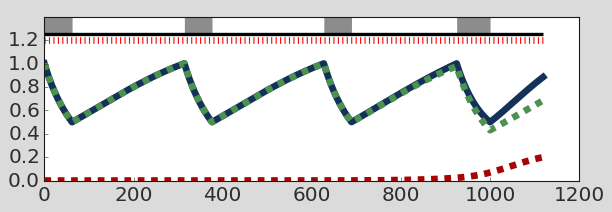

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

model = ExponentialModel(method='RK45', dt = 1)
model.SetParams(**expParamDic)
model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=2000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= expParamDic['N0']
model.resultsDf = model.resultsDf[model.resultsDf.R < 0.8 * expParamDic['Kr']]

print(f"Mean TTP under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

# plt.savefig("../figures/exo_model_example.pdf")

## Critical Threshold ($\alpha = 1$)

In [23]:
def calc_critical_threshold(tau, Ks, N0, rS, **_args):
    denominator = ((Ks / ( 1.2 * N0)) - 1) * np.exp(rS * tau) + 1
    return Ks / denominator


In [25]:
print(f"Critical threshold size is {calc_critical_threshold(100, **expParamDic):.2f}")

Critical threshold size is 0.92


Mean TTP under Adaptive Therapy is 1045 days


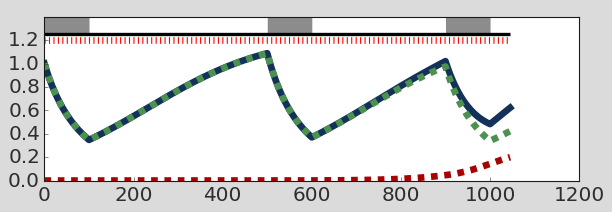

In [27]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

model = ExponentialModel(method='RK45', dt = 1)
model.SetParams(**expParamDic)
model.Simulate_AT(atThreshold=0.9, intervalLength=100, t_end=2000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= expParamDic['N0']
model.resultsDf = model.resultsDf[model.resultsDf.R < 0.8 * expParamDic['Kr']]

print(f"Mean TTP under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

# plt.savefig("../figures/exo_model_example.pdf")

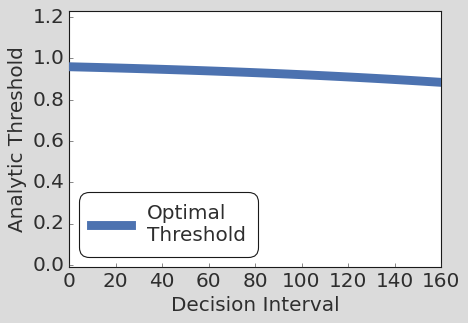

In [30]:
plt.rcParams['font.size'] = '18'
fig, ax = plt.subplots(1,1,figsize=(6,4))

tau_values = np.linspace(0, 160, 100)
n_stars = [calc_critical_threshold(tau=t,**expParamDic) for t in tau_values]
ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, label = 'Optimal\nThreshold'); 

# val = calc_critical_treatment_interval(n_crit = 0.5 * n0,**odeParamDic) 
# ax.hlines(xmin=0, xmax=max(tau_values), y=0.5, linestyles="--", linewidth=6, color=colors['AT'])
# ax.vlines(ymin=0, ymax=0.5, x=val, linestyles="--", linewidth=6, color=colors['AT'], label='AT50 Threshold')

ax.set_ylim(-0.01,1.23); ax.tick_params(right = False, top = False)
plt.gca().legend(loc=3, fontsize=18, numpoints=1, borderaxespad=0.7).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.xlabel("Decision Interval"); plt.ylabel("Analytic Threshold");

In [33]:
def calc_ttp(params, n_crit, interval):
    arg = n_crit/params['N0']
    model = ExponentialModel(dt=1); model.SetParams(**params)
    model.Simulate_AT(atThreshold=arg, atMethod='Threshold',
                    intervalLength=interval, t_end=6000, refSize = params['N0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2 * params['N0']]
    return model.resultsDf.Time.max()

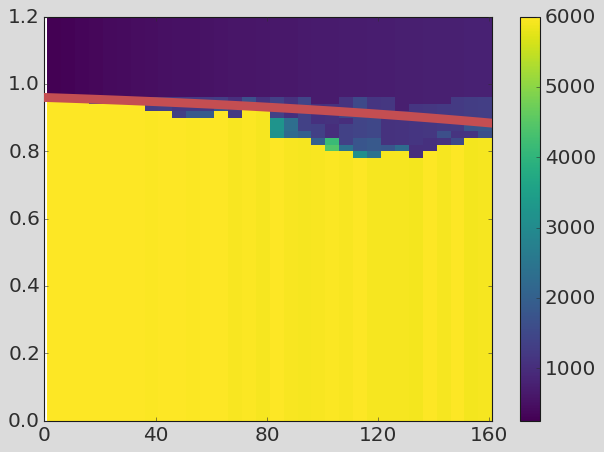

In [38]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

# make these smaller to increase the resolution
dx, dy = 1, 0.01
dx, dy = 5, 0.02

# generate 2 2d grids for the x & y bounds
crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]

vectorized_calc_ttp = np.vectorize(calc_ttp)
ttp_values = vectorized_calc_ttp(
    params = expParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid, crit_n_grid, ttp_values, 
                   cmap=plt.get_cmap('viridis'), norm=None)
fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='r', label = 'Optimal\nThreshold'); 

ax.set_xlim(0, np.max(tau_grid)); 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/exponential_model_threshold_a1.pdf"); plt.show()